# CaptionMe Project


---


We are working on a project which has the goal to generate some categories about a given image and  reciprocally.
To achieve this project we have listed the following steps :

## 1. Download the dataset of Flickr30K from Kaggle website

 * Download the datset using this URL :
 https://www.kaggle.com/hsankesara/flickr-image-dataset
 * Move it to your Drive 
 * Extract the data - unzip the folder - even if it takes a looooong time
 * Create a shortcut of `archive` into you `/content/drive/MyDrive`


[ COMPLETE THIS SECTION ]

---


<u>Note</u> :

<b>Flickr30K</b> contains <b>31783 images</b> with <b>5 different comments</b> corresponding to them. The idea there is to take a part of the dataset at the first 8000 images in total for those reasons :
* The memory capacity of Disk in Google Drive, Google Colab : we tested the way with the whole 31783 images dataset and taking only 1 comment per image, that is to say a total of 31783 comments. The result was very bad, around O.38 %  of accurray even trying to tune the model.
* The model of text generation should be trained on various comments per image to be more accurate and in order to reduce the loss and val loss. 

# 1 - Hardware

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat May 29 18:37:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


# 2 - Dataset Management

In [ ]:
# The first step is to mount our drives :
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Paths to the dataset
OWNER_DRIVE = "Merieme"
FLICKR_SEED_PATH_DIR = "/content/drive/MyDrive/archive/flickr30k_images/"
FLICKR_PATH_CSV = FLICKR_SEED_PATH_DIR + "results.csv"
FLICKR_PATH_DIR = FLICKR_SEED_PATH_DIR + "flickr30k_images/"
FLICKR_PATH_DIR_8K_5C = FLICKR_SEED_PATH_DIR + "flickr8K_5C/"
FLICKR_PATH_DIR_8K_5C_MODEL = FLICKR_PATH_DIR_8K_5C + "model_text_generation/"
FLICKR_PATH_DIR_8K_5C_MODEL_CHECKPOINTS_DIR = FLICKR_PATH_DIR_8K_5C_MODEL + "model_generation_sentences/"


# Pre-processing Data

<u>Way to proceed</u> :</br>
There are to ways to proceed in this project :
* <b>The first considers 5 comments per image</b> but we are not going to use this way because of the lack of memory :
   * All the images in the dataset has both <b>5 different comments</b> and <b>1 image in the folder</b>

   * The `flickr_csv` is a Dataframe containing the flickr30k dataset and other columns , the whole sorted by `image_name` column. 
* <b>The second considers 1 comment per image</b> and we are going to use this way fisrt !

We will thus condiser <b>`8000 images and 8000 * 5 = 40000 coments`</b>

In [ ]:
# Checkout the labels of our data
import pandas as pd
import os

flickr_csv = pd.read_csv(FLICKR_PATH_CSV, error_bad_lines=False, sep="|")
 
# We notice that there are spaces in the features names : let's removing them
# Columns : 'image_name', 'comment_number', 'comment'
flickr_csv.columns = [col.strip() for col in flickr_csv.columns]

# We notice that there are spaces in the leading of cells : let's removing them
for col in flickr_csv.columns:
  flickr_csv[col] = flickr_csv[col].apply(lambda x: str(x).lstrip())

# Put all the comments into lowercase
flickr_csv['comment'] = flickr_csv['comment'].apply(lambda x: x.lower())


# Add new column 'image_name_process' by concatenating 'image_name' without the extension '.jpg' and the 'comment_number'
flickr_csv["image_name_process"] = flickr_csv.apply(lambda row: row["image_name"].split(".")[0] + "." + row["comment_number"], axis=1)

# Sort flickr_csv by 'image_name_process'
flickr_csv = flickr_csv.sort_values("image_name_process")

# Keep only 8090 lines
flickr_csv = flickr_csv.loc[:8000*5-1]

flickr_csv.head()

,image_name,comment_number,comment,image_name_process
0,1000092795.jpg,0,two young guys with shaggy hair look at their ...,1000092795.0
1,1000092795.jpg,1,"two young , white males are outside near many ...",1000092795.1
2,1000092795.jpg,2,two men in green shirts are standing in a yard .,1000092795.2
3,1000092795.jpg,3,a man in a blue shirt standing in a garden .,1000092795.3
4,1000092795.jpg,4,two friends enjoy time spent together .,1000092795.4


Verifying if all the `image_name` in the `Dataframe flickr_csv` have an image in the folder `FLICKR_PATH_DIR`.

In [ ]:
# Verfify if an image_name corresponds to an existing image
image_name_in_folder = os.listdir(FLICKR_PATH_DIR)

cpt_index_images_name_to_drop = 0

for index, row in flickr_csv.iterrows():
  if row['image_name'] not in image_name_in_folder:
    cpt_index_images_name_to_drop += 1

if cpt_index_images_name_to_drop == 0:
  print("All image_name values in the dataset has an image in the folder !")
else:
  print("Some image_name values in the dataset hasn't an image in the folder !")

All image_name values in the dataset has an image in the folder !


Verifying if all the `image_name` in the `Dataframe flickr_csv` have 5 comments.

In [ ]:
# Verify how many comments are there for every image
flickr_gbcount = flickr_csv.groupby("image_name").count()

# Count the number of 'image_name_process' after groupby and count inferior to 5
cpt = 0

for index, row in flickr_gbcount.iterrows():
  if row["image_name_process"] == 5:
    cpt += 1

if len(flickr_gbcount) == cpt:
  print("All the images have 5 comments !")
else:
  print("Some images have less that 5 comments !\nThis must be due to the reduction number to 1 of comments per image...")


All the images have 5 comments !


In [ ]:
flickr_gbcount.head()

,comment_number,comment,image_name_process
image_name,,,
1000092795.jpg,5,5,5
10002456.jpg,5,5,5
1000268201.jpg,5,5,5
1000344755.jpg,5,5,5
1000366164.jpg,5,5,5


## Remove punctuation

Punctuation can provide grammatical context to a sentence which supports our understanding. But for our vectorizer which counts the number of words and not the context, it does not add value, so we remove all special characters. eg: How are you?->How are you

In [ ]:
import string

# Function to remove the punctuation
def remove_punctuation(text):
  """
  Takes a text and remove its punctuation.
  """
  text_without_punct = "".join([char for char in text if char not in string.punctuation])

  return text_without_punct

flickr_csv["comment_text_clean"] = flickr_csv["comment"].apply(lambda x: remove_punctuation(str(x)))

flickr_csv.head()

,image_name,comment_number,comment,image_name_process,comment_text_clean
0,1000092795.jpg,0,two young guys with shaggy hair look at their ...,1000092795.0,two young guys with shaggy hair look at their ...
1,1000092795.jpg,1,"two young , white males are outside near many ...",1000092795.1,two young white males are outside near many b...
2,1000092795.jpg,2,two men in green shirts are standing in a yard .,1000092795.2,two men in green shirts are standing in a yard
3,1000092795.jpg,3,a man in a blue shirt standing in a garden .,1000092795.3,a man in a blue shirt standing in a garden
4,1000092795.jpg,4,two friends enjoy time spent together .,1000092795.4,two friends enjoy time spent together


## Tokenization

Tokenizing separates text into units such as sentences or words. It gives structure to previously unstructured text. eg: Plata o Plomo-> ‘Plata’,’o’,’Plomo’.

In [ ]:
import re

# Function to Teokenize words
def tokenize(text):
  """
  Takes a text and tokenize it.
  """
  # W+ means that either a word character (A-Za-z0-9_) or a dash (-) is accepted
  tokens = re.split("\W+", text) 

  return tokens

flickr_csv["comment_text_tokenized"] = flickr_csv["comment_text_clean"].apply(lambda x: tokenize(x))

flickr_csv.head()

,image_name,comment_number,comment,image_name_process,comment_text_clean,comment_text_tokenized
0,1000092795.jpg,0,two young guys with shaggy hair look at their ...,1000092795.0,two young guys with shaggy hair look at their ...,"[two, young, guys, with, shaggy, hair, look, a..."
1,1000092795.jpg,1,"two young , white males are outside near many ...",1000092795.1,two young white males are outside near many b...,"[two, young, white, males, are, outside, near,..."
2,1000092795.jpg,2,two men in green shirts are standing in a yard .,1000092795.2,two men in green shirts are standing in a yard,"[two, men, in, green, shirts, are, standing, i..."
3,1000092795.jpg,3,a man in a blue shirt standing in a garden .,1000092795.3,a man in a blue shirt standing in a garden,"[a, man, in, a, blue, shirt, standing, in, a, ..."
4,1000092795.jpg,4,two friends enjoy time spent together .,1000092795.4,two friends enjoy time spent together,"[two, friends, enjoy, time, spent, together, ]"


# 3 - End to End caption generator 

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model

from IPython.display import Image
from datetime import datetime
import time
import os

from pickle import dump

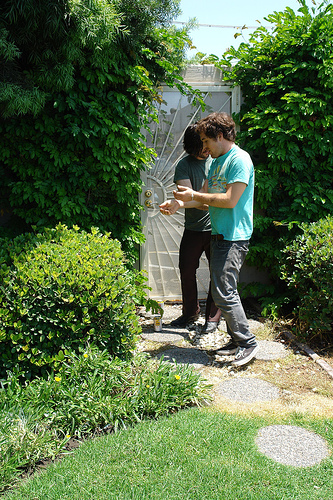

In [ ]:
# Display one image
Image('/content/drive/MyDrive/L3 DANT/Data-Science/archive/flickr30k_images/flickr30k_images/1000092795.jpg')

## Data preprocessing

 1 - Transform `comment` column into lowercase</br>
 2 - Remove punctuation of `comment` column --> store into `comment_text_clean` column</br>
 3 - Tokenize `comment_text_clean` column --> store into `comment_text_tokenized`</br>
 4 - Add `"startseq"` and `"endseq"` respetively at the begining and at the end of the comment for each row of `comment_text_clean`. This way will <b>allow the model to detect when the sentence begins and when it ends</b> --> store into `surrounded` column

 You have certainly noticed that we are not using  `comment_text_tokenized`, this is because we will probably test different ways to perform all the steps to improve our execution scores.

In [ ]:
# Add new column 'comment_text_surrounded' by concatenating 'startseq', 'comment_text_tokenized' and 'endseq' together
flickr_csv["comment_text_surrounded"] = flickr_csv["comment_text_tokenized"].apply(lambda x : 'startseq ' + ' '.join(x) + ' endseq')
flickr_csv.head()

,image_name,comment_number,comment,image_name_process,comment_text_clean,comment_text_tokenized,comment_text_surrounded
0,1000092795.jpg,0,two young guys with shaggy hair look at their ...,1000092795.0,two young guys with shaggy hair look at their ...,"[two, young, guys, with, shaggy, hair, look, a...",startseq two young guys with shaggy hair look ...
1,1000092795.jpg,1,"two young , white males are outside near many ...",1000092795.1,two young white males are outside near many b...,"[two, young, white, males, are, outside, near,...",startseq two young white males are outside nea...
2,1000092795.jpg,2,two men in green shirts are standing in a yard .,1000092795.2,two men in green shirts are standing in a yard,"[two, men, in, green, shirts, are, standing, i...",startseq two men in green shirts are standing ...
3,1000092795.jpg,3,a man in a blue shirt standing in a garden .,1000092795.3,a man in a blue shirt standing in a garden,"[a, man, in, a, blue, shirt, standing, in, a, ...",startseq a man in a blue shirt standing in a g...
4,1000092795.jpg,4,two friends enjoy time spent together .,1000092795.4,two friends enjoy time spent together,"[two, friends, enjoy, time, spent, together, ]",startseq two friends enjoy time spent together...


In [ ]:
flickr_csv.describe

<bound method NDFrame.describe of            image_name  ...                            comment_text_surrounded
0      1000092795.jpg  ...  startseq two young guys with shaggy hair look ...
1      1000092795.jpg  ...  startseq two young white males are outside nea...
2      1000092795.jpg  ...  startseq two men in green shirts are standing ...
3      1000092795.jpg  ...  startseq a man in a blue shirt standing in a g...
4      1000092795.jpg  ...  startseq two friends enjoy time spent together...
...               ...  ...                                                ...
39995  2702682262.jpg  ...  startseq a tattooed man sitting on a sidewalk ...
39996  2702682262.jpg  ...  startseq a man sits on the sidewalk head in ha...
39997  2702682262.jpg  ...  startseq dejected man sits crossedlegged with ...
39998  2702682262.jpg  ...  startseq a man sitting on sidewalk with shirt ...
39999  2702682262.jpg  ...  startseq depressed man who does not know what ...

[40000 rows x 7 columns]>

In [ ]:
# List of all caption names
caption_images_list = []

# We make a verification of unique image even if we are using 1 or 5 comments
image_index = list(map(lambda x: x.split(".")[0] , flickr_csv["image_name"].unique().tolist()))

print("Number of unique image_name : " + str(len(image_index)))

Number of unique image_name : 8000


To split efficiently our dataset of <b>8000 samples</b>, we will use the commonly used <b>ratio 70-15-15</b>:
* <b>70% ≃ 5600</b> --> Training Set
* <b>15% ≃ 1200</b> --> Validation Set
* <b>15% ≃ 1200</b> --> Testing Set

In [ ]:
# Split the list into train validate (5600 + 1200) and test (1200) samples 
train_validate_images = image_index[:5600 + 1200]
test_images = image_index[5600 + 1200:]
  
  
print("Number of training samples/images : " + str(len(train_validate_images)))
print("Number of testing samples/images  : " + str(len(test_images)))
print("Total                             : " + str(len(train_validate_images) + len(test_images)))

Number of training samples/images : 6800
Number of testing samples/images  : 1200
Total                             : 8000


The following cell will make feature predictions on training images using pre trained VGG16 model. The prediction will be saved in a `.pkl` binary file called `train_validate_feature_[date & time].pkl`.

This backup of the model allows us to use the predictions by loading the file and thus avoid to rerun the cell and waist al lot of time. 

<u>Note</u> :
* The `if False:` is there just in case someone run this cell without reading the doc.    
* Running this cell on <b>158815 samples</b> took <b>19516 sec ≃ 05:24:00 hours</b>. Since there are only unique 31783 samples in the dataset, it was useless and a waist of time.
* Runing this cell on <b>27016 samples </b>took <b>8098 sec ≃ 02:15:00 hours</b>.

Whether we use 1 or 5 comments, the splitting stay the same.


In [ ]:
# +------------------------------------------------------------------------------------------------------------+
# |                 DO NOT RUN THIS CELL IF THE MODEL HAS ALREADY BEEN SAVED IN A '.pkl' FILE                  |
# +------------------------------------------------------------------------------------------------------------+

from pickle import dump
from datetime import datetime
import time

# extract features from each photo in the directory
def extract_features(directory, image_keys):
    # load the model
    model = VGG16()
    
    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    
    # summarize
    print(model.summary())
      
    # extract features from each photo
    features = dict()

    # counter
    counter = 0
    
    for name in image_keys:
        
        # load an image from file
        filename = directory + name + '.jpg'
        
        # load the image and convert it into target size of 224*224
        image = load_img(filename, target_size=(224, 224))
        
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        
        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        
        # prepare the image for the VGG model
        image = preprocess_input(image)
        
        # get features
        feature = model.predict(image, verbose=0)
        
        # get image id
        image_id = name.split('.')[0]
        
        # store feature
        features[image_id] = feature
        
        counter += 1
        print("Iter nb : " + str(counter))
        

    return features


start_time = time.time()

# Extracting image features for train_validate_images
train_validate_features = extract_features(FLICKR_PATH_DIR, train_validate_images)

print("--- %s seconds ---" % (time.time() - start_time))

now = datetime.now()

# dd-mm-YY_H-M-S
dt_string = now.strftime("%d-%m-%Y_%H-%M-%S")
filename = FLICKR_PATH_DIR_8K_5C + 'train_validate_features_' + dt_string + '.pkl'

# Save the model .pkl file
dump(train_validate_features, open(filename, 'wb'))

<u>Note</u> :
` train_validate_features` as the following format:
```python
  """ 
  Contains the features extraction of VGG16 for a given image_name
  """

  dict(string : list(flaot32)) train_validate_feature
```

In [ ]:
import pickle

# Load the Model back from file
dt_string = "28-05-2021_13-21-58"
fn_pkl_8K_5C = FLICKR_PATH_DIR_8K_5C + 'train_validate_features_' + dt_string + '.pkl' 

with open(fn_pkl_8K_5C, 'rb') as file:  
    # 
    train_validate_features = pickle.load(file)

## Preparating data for the machine learning model that make sentences

In [ ]:
# load libraries
import numpy as np
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout, LSTM, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, plot_model
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sys import getsizeof

In [ ]:
print("Number of training and validation samples : " + str(len(train_validate_features)))

Number of training and validation samples : 6800


In [ ]:
print("{} : {}".format(list(train_validate_features.keys())[0], train_validate_features[list(train_validate_features.keys())[0]] ))

1000092795 : [[3.896554   3.8459592  0.         ... 0.         0.63518006 1.1603202 ]]


<b> THIS IS A IDEAL CASE USING THE WHOLE DATASET OF 158915 SAMPLES!</b></br>
As said above, every caption have 5 comments so we will be able to train and validate our sentence predictions model over `5 * len(train_validate_features) = 5 * 6800 = ` <b>`34000`</b>.</br>
<u>Let see an example</u> :
* <b>image_name</b> : 1000092795.jpg
  <table>
    <thead>
      <tr>
        <th>comment_number</th>
        <th>comment</th>
      </tr>
    </thead>

    <tbody>
      <tr>
        <td>0</td>
        <td>two young guys with shaggy hair look at their hands while hanging out in the yard .</td>
      </tr>
      <tr>
        <td>1</td>
        <td>two young , white males are outside near many bushes .</td>
      </tr>
      <tr>
        <td>2</td>
        <td>two men in green shirts are standing in a yard .</td>
      </tr>
      <tr>
        <td>3</td>
        <td>a man in a blue shirt standing in a garden .</td>
      </tr>
      <tr>
        <td>4</td>
        <td>two friends enjoy time spent together .</td>
      </tr>
    </tbody>
  </table>


---


<strike><b> THIS IS A POSSIBLE CASE NOT USING THE WHOLE DATASET BUT ONLY 31783 SAMPLES!</b></br>
As said above, every caption have <b>5 comments but our memory capacity is limited</b> to the storage available on a Googel Drive account. Therefore, we are only going to deal with <b>1 comment per image</b>, the one with a `image_name_process` ending by `.0`.</br>
To split efficiently our dataset of <b>31783 samples</b>, we will use the commonly used <b>ratio 70-15-15</b>:
* <b>70% ≃ 22249</b> --> Training Set
* <b>15% ≃ 4767</b> --> Validation Set
* <b>15% ≃ 4767</b> --> Testing Set
</strike>

In [ ]:
# Make a dictionary : { 'image_name_process' : 'comment_text_surrounded'}
train_validate_image_caption = {}

list_keys_train_validate_features = list(train_validate_features.keys())

for index, row in flickr_csv.iterrows():
    """
    """

    # Check whether the image is available in both train_validate_images list and train_validate_features dictionary
    image_name = row["image_name"].split('.')[0]

    if (image_name in train_validate_images) and (image_name in list_keys_train_validate_features):
        
        train_validate_image_caption.update({row["image_name_process"] : row["comment_text_surrounded"]})

print(len(train_validate_image_caption))

34000


In [ ]:
if (len(train_validate_image_caption) == len(train_validate_images) * 5 
    and len(train_validate_image_caption) == len(list_keys_train_validate_features) * 5): 
    print("Training-Validation set has 5 comments for each training-validation images and key validation feature ! \
          \ne.g We have a set of 5 comments per training-validation captions and features !")
else:
  print("Training-Validation set has not 5 comments for each training-validation images and key validation feature ! \
          \ne.g We haven't got a set of 5 comments per training-validation captions and features.\
          \nIf it's not an error and you're juste using 1 comment -> OK\
          \nElse -> FIX IT BEFORE CONTINUING !")

Training-Validation set has 5 comments for each training-validation images and key validation feature !           
e.g We have a set of 5 comments per training-validation captions and features !


<u>Note</u> :
* Since keys of `train_validate_image_caption` dictionary are `image_name_process` and thus has the following format `IMAGE_NAME.COMMENT_NUMBER` (ex : `1000092795.0`), it's needed to <b>extract the `image_name` without the `comment_number` for some processes</b>.

* `train_validate_image_caption.values()` contains noting else than the `flickr_csv`column `comment_text_surronded`

In [ ]:
print(list(train_validate_image_caption.values())[0])
print(list(train_validate_image_caption.keys())[0])

startseq two young guys with shaggy hair look at their hands while hanging out in the yard  endseq
1000092795.0


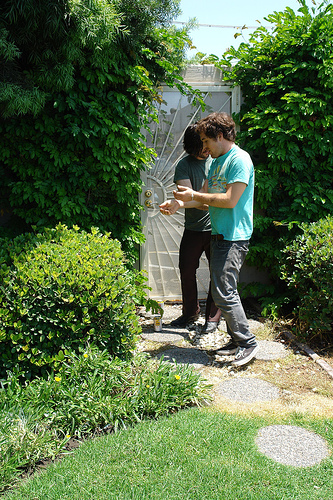

In [ ]:
Image(FLICKR_PATH_DIR + list(train_validate_image_caption.keys())[0].split(".")[0] + '.jpg')

In [ ]:
# Initialize tokenizer
tokenizer = Tokenizer()

# Create word count dictionary on captions list
tokenizer.fit_on_texts(list(train_validate_image_caption.values()))

# How many words are there in the vocabulary?
# store the total length in vocab_len and add 1 because word_index starts with 1 not 0
vocab_len = len(tokenizer.word_index) + 1

# Iterate over train_validate_image_cation values
# Split each value and take the length
# Store the length of the maximum sentence
max_len = max(len(train_validate_image_caption[image].split()) for image in train_validate_image_caption)

In [ ]:
print(train_validate_images)

['1000092795', '10002456', '1000268201', '1000344755', '1000366164', '1000523639', '1000919630', '10010052', '1001465944', '1001545525', '1001573224', '1001633352', '1001773457', '1001896054', '100197432', '100207720', '1002674143', '1003163366', '1003420127', '1003428081', '100444898', '1005216151', '100577935', '1006452823', '100652400', '1007129816', '100716317', '1007205537', '1007320043', '100759042', '10082347', '10082348', '100845130', '10090841', '1009434119', '1009692167', '101001624', '1010031975', '1010087179', '1010087623', '10101477', '1010470346', '1010673430', '101093029', '101093045', '1011572216', '1012150929', '1012212859', '1012328893', '101262930', '1013536888', '101362133', '101362650', '1014609273', '101471792', '1014785440', '1015118661', '1015584366', '101559400', '1015712668', '10160966', '101654506', '1016626169', '101669240', '1016887272', '1017675163', '1018057225', '1018148011', '101859883', '10188041', '1019077836', '101958970', '1019604187', '102030371', 

In [ ]:
# Get all rows (e.g all captions) which has train_validate_images values
# Thus we have to take all the rows whose its image_name has been trained previously
train_validate_images_processed = [row["image_name_process"] for index, row in flickr_csv.iterrows() if row["image_name"].split(".")[0] in train_validate_images]

len(train_validate_images_processed)

34000

<u>Note</u>:
* As said earlier, we split our initial <b>8000 * 5 = 40000 samples</b> dataset following the commonly used <b>ratio 70-15-15</b>:
  * <b>70% ≃ 28000</b> --> Training Set  --> `BATCH_SIZE = 1750`
  * <b>15% ≃ 6000</b> --> Validation Set --> `BATCH_SIZE = 375`
  * <b>15% ≃ 6000</b> --> Testing Set 
* <strike>Since now we are not dealing with unique images ans thus `image_name` we will apply a factor of 5, corresponding to the number of comments available for each image. Moreover, don't forget that the Training and Validation part should represent 135080 samples. Thus, spliting our 158915 data using same way, gives us those results:
  * <b>70% ≃ 111243</b> --> Training Set
  * <b>15% ≃ 23837</b> --> Validation Set --> `BATCH_SIZE = 33`
  * <b>15% ≃ 23837</b> --> Testing Set --> `BATCH_SIZE = 11`</strike>
* To observe the <b>time</b> taken by the construction of each training and validation text set, let's print the timers.

<u>Note :</u></br>
* Each caption will be splitted into words. 
* The model will be <b>provided one word and the photo and generate the next word</b>.
* Then the <b>first two words of the description</b> will be provided to the model as <b>input with the image to generate the next word</b>. This is how the model will be trained. 
* So we will have two features, `x1` (image) , `x2` (text_sequence) and one target variable, `y`.

In [ ]:
def prepare_data(image_keys):
    """
    """

    # x1  will store the image feature
    # x2  will store one sequence
    # y   will store the next sequence
    x1, x2, y = [], [], []

    # Iterate through all the images 
    for image in image_keys:

        # Store the caption of that image took of train_validate_image_caption
        caption = train_validate_image_caption[image]

        # Split the image into tokens
        seq = tokenizer.texts_to_sequences([caption])[0]

        length = len(seq)

        for i in range(1, length):

            x2_seq, y_seq = seq[:i] , seq[i]  

            # Pad the sequences
            # +-------------------------------------------------+
            # |             Output is a sparce matrix           |
            # |                                                 |
            # | * we can try other methods to avoid this format |
            # +-------------------------------------------------+
            x2_seq = pad_sequences([x2_seq], maxlen = max_len)[0]


            # Encode the output sequence                
            y_seq = to_categorical([y_seq], num_classes = vocab_len)[0]

            x1.append( train_validate_features[image.split(".")[0]][0] )

            x2.append(x2_seq)

            y.append(y_seq)
                
    return x1, x2, y

In [ ]:
# Function that store a nested list of floats into a filename using a mode
def store_prepare_data(filename, mode, data):
  """
  Store :   data list(list(float32)) 
  Into  :   filename 
  Using :   mode ('w', 'a')
  """

  try:
    with open(filename, mode) as file:
      for list1 in data:
        for i in range(0, len(list1)):
          file.write(str(list1[i]))
          if i != (len(list1) -1):
            file.write(",")
        file.write("\n") 
    return True
  except:
    return False

In [ ]:
# Number of samples handled at the same time, it must be a divider of the number of data de select
BATCH_SIZE_TRAIN = 1750
BATCH_SIZE_VAL   = 375
x1_train, x2_train, y_train = [], [], []

# Montoring the memory consume
monitoring_cumulated_memory_size = pd.DataFrame(
    columns=["number_samples", 
             "memory_size_image_features", 
             "memory_size_sequences", 
             "memory_size_next_sequence"]
             )
fn_train_x1 = FLICKR_PATH_DIR_8K_5C_MODEL + 'train_x1_other' + '.txt'
fn_train_x2 = FLICKR_PATH_DIR_8K_5C_MODEL + 'train_x2_other' + '.txt'
fn_train_y = FLICKR_PATH_DIR_8K_5C_MODEL + 'train_y_other' + '.txt'

fn_validate_x1 = FLICKR_PATH_DIR_8K_5C_MODEL + 'validate_x1_other' + '.txt'
fn_validate_x2 = FLICKR_PATH_DIR_8K_5C_MODEL + 'validate_x2_other' + '.txt'
fn_validate_y = FLICKR_PATH_DIR_8K_5C_MODEL + 'validate_y_other' + '.txt'


<u>Warning</u> :
* Since the training and validation variables have already been computed and stored, <b>runing the following cell is useless !</b>
* The `if False:` is there just in case someone run this cell without reading the documentation.    

In [ ]:
# if False :
print("Computing and processing training data ...")
for  i in range(0, len(train_validate_images_processed[0:28000]), BATCH_SIZE_TRAIN):
  
  train_x1,     train_x2,     train_y     = prepare_data( train_validate_images_processed[i:i+BATCH_SIZE_TRAIN] )

  # +-------------------------------------------------+
  # |       UNCOMMENT TO STORE AGAIN THE DATA         |    
  # +-------------------------------------------------+
  # | 1- Change the file names to not overwrite them  |
  # | 2- Run the cell                                 |
  # +-------------------------------------------------+
  print("Storring data {} ...".format(i))
  store_prepare_data(fn_train_x1, 'a', train_x1)
  store_prepare_data(fn_train_x2, 'a', train_x2)
  store_prepare_data(fn_train_y, 'a', train_y)


  # monitoring_cumulated_memory_size = monitoring_cumulated_memory_size.append(
  #    {"number_samples": i+BATCH_SIZE, 
  #     "memory_size_image_features":  getsizeof(x1_train),
  #     "memory_size_sequences":       getsizeof(x2_train),
  #     "memory_size_next_sequence":   getsizeof(y_train)
  #     }, ignore_index=True)

del train_x1
del train_x2 
del train_y

print("Computing and processing validation data ...")
for  i in range(0, len(train_validate_images_processed[28000:28000+6000]), BATCH_SIZE_VAL):
  
  validate_x1,  validate_x2,  validate_y    = prepare_data( train_validate_images_processed[i:i+BATCH_SIZE_VAL] )

  # +-------------------------------------------------+
  # |       UNCOMMENT TO STORE AGAIN THE DATA         |    
  # +-------------------------------------------------+
  # | 1- Change the file names to not overwrite them  |
  # | 2- Run the cell                                 |
  # +-------------------------------------------------+
  print("Storring data {} ...".format(i))
  store_prepare_data(fn_validate_x1, 'a', validate_x1)
  store_prepare_data(fn_validate_x2, 'a', validate_x2)
  store_prepare_data(fn_validate_y, 'a', validate_y)

Computing and processing training data ...
Storring data 0 ...
Storring data 1750 ...
Storring data 3500 ...
Storring data 5250 ...
Storring data 7000 ...
Storring data 8750 ...
Storring data 10500 ...
Storring data 12250 ...
Storring data 14000 ...
Storring data 15750 ...
Storring data 17500 ...
Storring data 19250 ...
Storring data 21000 ...
Storring data 22750 ...
Storring data 24500 ...
Storring data 26250 ...
Computing and processing validation data ...
Storring data 0 ...
Storring data 375 ...
Storring data 750 ...
Storring data 1125 ...
Storring data 1500 ...
Storring data 1875 ...
Storring data 2250 ...
Storring data 2625 ...
Storring data 3000 ...
Storring data 3375 ...
Storring data 2625 ...
Storring data 3000 ...
Storring data 3750 ...
Storring data 4125 ...
Storring data 4500 ...
Storring data 4875 ...
Storring data 5250 ...
Storring data 5625 ...


## Sentence generation model

### Model architecture
This section presents the model of sentence generation. It uses block of <b>Keras layers</b> with the following specificities:

* <u>Feature extractor block :</u>

  * `Input layer` : This as an input shape of `(4096,)` because it's the shape of the output predictions of VGG16.

  * `Dropout layer` : This is a regularizer technique that <b>reduces the odds of overfitting</b> by dropping out neurons at random, during every epoch (or, when using a minibatch approach, during every minibatch). </br>
  <b>Dropping out neurons</b> happens by attaching Bernoulli variables to the neural outputs (Srivastava et al., 2014). These variables, which take the value of 1 with probability p and 0 with 1−p, <b>help reduce overfitting by “making the presence of other (..) units unreliable”</b>. </br>

    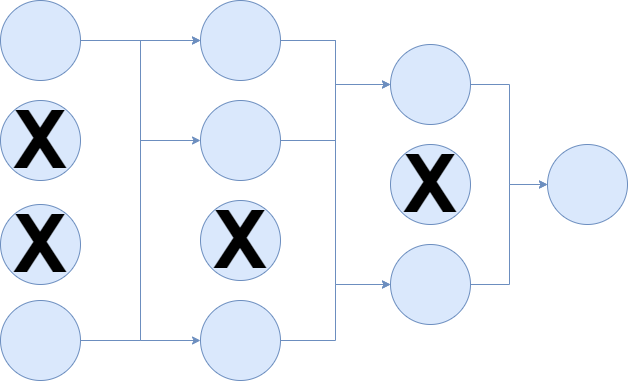 
  </br>
  * `Dense layer` : Let's see what this will look like.</br>
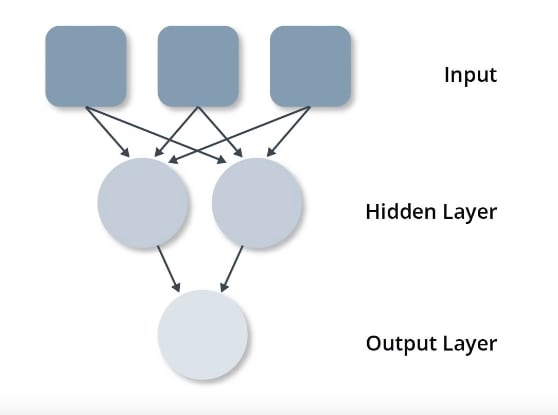
</br>

    These types of layers are fully connected or dense layers. So when we use a dense layer in keras , we're simply stating that the neurons in that layer are fully connected to the neurons in the previous layer.

  * <u>Sequence model :</u>
    * `Input layer` : This as an input shape of `(max_len,)` corresponding to the length of the maximum sentence.

    * `Embedding layer` : A word embedding is a class of approaches for representing words and documents using a dense vector representation.. It requires that the input data be integer encoded, so that each word is represented by a unique integer. This data preparation step can be performed using the Tokenizer API also provided with Keras.

      The Embedding layer is initialized with random weights and will learn an embedding for all of the words in the training dataset.

      It is a flexible layer that can be used in a variety of ways, such as:

      * It can be used alone to learn a word embedding that can be saved and used in another model later.
      * It can be used as part of a deep learning model where the embedding is learned along with the model itself.
      * It can be used to load a pre-trained word embedding model, a type of transfer learning.
    
    * `LSTM layer` : An LSTM layer above provides a sequence output rather than a single value output to the LSTM layer below. Specifically, one output per input time step, rather than one output time step for all input time steps.</br>
    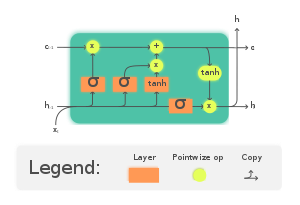

In [ ]:
# Feature extractor model
input_1     = Input(shape=(4096,))
droplayer   = Dropout(0.5)(input_1)
denselayer  = Dense(256, activation='relu')(droplayer)

# Sequence model
input_2     = Input(shape=(max_len,))
embedding   = Embedding(vocab_len, 256, mask_zero=True)(input_2)
droplayer_  = Dropout(0.5)(embedding)
lstm        = LSTM(256)(droplayer_)

# Decoder model
decoder1    = add([denselayer, lstm])
decoder2    = Dense(256, activation='relu')(decoder1)
outputs     = Dense(vocab_len, activation='softmax')(decoder2)

# Optimizer 
optimizer   = Adam(learning_rate=0.001)

# Tie it together [image, seq] [word]
model = Model(inputs=[input_1, input_2], 
              outputs=outputs)

model.compile(loss      = 'categorical_crossentropy', 
              optimizer = optimizer,
              metrics   = ["accuracy"])

# Summarize model
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 80, 256)      2581760     input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 4096)         0           input_1[0][0]                    
______________________________________________________________________________________________

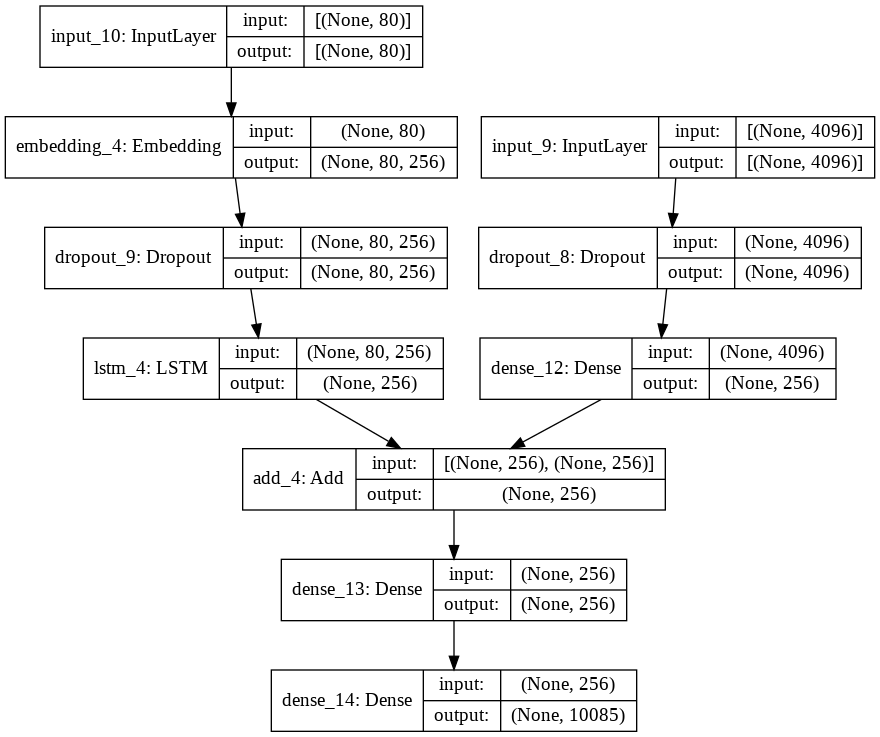

In [ ]:
fn_model = FLICKR_PATH_DIR_8K_5C_MODEL + "model.png"
plot_model(model, to_file=fn_model, show_shapes=True)

<u> Way to proceed</u> :

* As the trainning and validation data is memory consuming, having them into variables and thus in RAM is impossible and not reasonable. That's why we previously stored this data in 6 different files.
* We are going to be able to create a generator that act like an iterator and pass it to `model.fit()` methode. Therefore, it will be possible to load data per `BATCH_SIZE_LOAD` to not exceed the RAM memory capacity.
* The model with thus deal with a `BATCH_SIZE_LOAD` data size.

In [ ]:
def read_nested_array_from_file(filename):
  """
  String -> List(List(float32))
  """
  lr = []
  cpt = 0
  with open(filename, 'r') as file:
    for line in file:
      #list_line = line.split(",")
      #list_line[len(list_line)-1] = list_line[len(list_line)-1].rstrip('\n')
      #lr.append(line.split(","))
      cpt += 1

  #return lr
  return cpt

In [ ]:
tx1 = read_nested_array_from_file(fn_train_x1)
print(tx1)
tx2 = read_nested_array_from_file(fn_train_x2)
print(tx2)
ty = read_nested_array_from_file(fn_train_y)
print(ty)

365601
365601
365601


In [ ]:
tx1 = read_nested_array_from_file(fn_validate_x1)
print(tx1)
tx2 = read_nested_array_from_file(fn_validate_x2)
print(tx2)
ty = read_nested_array_from_file(fn_validate_y)
print(ty)

79332
79332
79332


<u>Note</u> :</br>
We assume taking 1 coment per image.
* The 3 following <b>training</b> files :
  * `train_x1_other.txt` in `fn_train_x1` variable  
  * `train_x2_other.txt` in `fn_train_x2` variable
  * `train_y_other.txt` in `fn_train_y` variable

  ... contain <b>365601</b> lines. This is a difficult number wcause wie have to use a `BATCH_SIZE` between for example `[[60;600]]` and this number could only give us a `BATCH_SIZE = 3` which is too small. Therefore, we will <b>not consider the laster element</b> and thus have <b>365600</b> elements. 
  ```bash
  # Do this for the 3 files of training
  head -n -1 NAME_OF_TRAINING_FILE.txt > TMP_NAME_TRAINING_FILE.txt
  mv TMP_NAME_TRAINIG_FILE.txt NAME_OF_TRAINING_FILE.txt

  # Verify the number lines
  wc -n -1 NAME_OF_TRAINING_FILE.txt
  ```
  Thus, we will use a <b>`BATCH_SIZE_LOAD_TRAINING = 1828`</b>

* The 3 following <b>validation</b> files :
  * `validate_x1_other.txt` in `fn_validate_x1` variable  
  * `validate_x2_other.txt` in `fn_validate_x2` variable
  * `validate_y_other.txt` in `fn_validate_y` variable

  ... contain <b>79332</b> lines. Thus, we will use a <b>`BATCH_SIZE_LOAD_VALIDATION = 1202`</b>

In [ ]:
checkpoint_path = FLICKR_PATH_DIR_8K_5C_MODEL_CHECKPOINTS_DIR + "model-ep04-loss3.866-val_loss3.746.ckpt"

# Since my model has already been trained, we lead the weight using the checkpoints
model.load_weights(checkpoint_path)

In [ ]:
model.history

In [ ]:
BATCH_SIZE_LOAD_TRAINING = 1828
BATCH_SIZE_LOAD_VALIDATION = 1202

# Generator that takes file paths of x1, x2 and y and a batch_size and yields the output data corresponding to the input training of the model
def generate_nested_array_from_file(path_x1, path_x2, path_y, batch_size):
  """
  String * String * String * int -> Array(np.array(np.array(float32)) * np.array(float32))
  Hypothese : the 3 files constains the same number of lines.
  """
  inputs_1 = []
  inputs_2  = []
  targets = []
  batch_count = 0

  while True:
    with open(path_x1, 'r') as f_x1, open(path_x2, 'r') as f_x2, open(path_y, 'r') as f_y:

          # Iterate over the 3 files to extract the lists in each line
          for line_f_x1, line_f_x2, line_f_y in zip(f_x1, f_x2, f_y):

            # Process x1
            x1            = line_f_x1.split(",")
            x1[len(x1)-1] = x1[len(x1)-1].rstrip('\n')

            # Process x2
            x2            = line_f_x2.split(",")
            x2[len(x2)-1] = x2[len(x2)-1].rstrip('\n')

            # Process y
            y           = line_f_y.split(",")
            y[len(y)-1] = y[len(y)-1].rstrip('\n')

            # Agregate all the lists
            inputs_1.append(x1)
            inputs_2.append(x2)
            targets.append(y)

            batch_count += 1

            if batch_count > batch_size:
              X1  = np.array(inputs_1, dtype='float32')
              X2  = np.array(inputs_2, dtype='float32')
              Y   = np.array(targets, dtype='float32')
              yield ([X1, X2], Y)
              inputs_1  = []
              inputs_2  = []
              targets   = []
              batch_count = 0


# Define checkpoint callback
fn_model_sentence_generation = FLICKR_PATH_DIR_8K_5C_MODEL_CHECKPOINTS_DIR + 'model-ep{epoch:02d}-loss{loss:.3f}-val_loss{val_loss:.3f}.ckpt'

model_checkpoint_callback = ModelCheckpoint(filepath          = fn_model_sentence_generation, 
                                            monitor           = 'val_accuracy', 
                                            mode              = 'max',
                                            save_best_only    = True,
                                            save_weights_only = True) 


# Fit model
# Model weights are saved at the end of every epoch, if it's the best seen so far.
history = model.fit(generate_nested_array_from_file(fn_train_x1, fn_train_x2, fn_train_y, BATCH_SIZE_LOAD_TRAINING),   
                    steps_per_epoch   = 409335 / BATCH_SIZE_LOAD_TRAINING,           
                    verbose           = 1,            
                    epochs            = 20,            
                    callbacks         = [model_checkpoint_callback], 
                    validation_data   = generate_nested_array_from_file(fn_validate_x1, fn_validate_x2, fn_validate_y, BATCH_SIZE_LOAD_VALIDATION),
                    validation_steps  = 88309 / BATCH_SIZE_LOAD_VALIDATION) 



Epoch 1/20
223/223 [==============================] - 1536s 7s/step - loss: 3.2912 - accuracy: 0.3557 - val_loss: 3.1625 - val_accuracy: 0.3679
Epoch 2/20
223/223 [==============================] - 1554s 7s/step - loss: 3.2729 - accuracy: 0.3575 - val_loss: 3.1215 - val_accuracy: 0.3695
Epoch 3/20
223/223 [==============================] - 1571s 7s/step - loss: 3.2546 - accuracy: 0.3592 - val_loss: 3.1185 - val_accuracy: 0.3720
Epoch 4/20
223/223 [==============================] - 1563s 7s/step - loss: 3.2446 - accuracy: 0.3599 - val_loss: 3.1377 - val_accuracy: 0.3708
Epoch 5/20
223/223 [==============================] - 1554s 7s/step - loss: 3.2293 - accuracy: 0.3623 - val_loss: 3.1170 - val_accuracy: 0.3716
Epoch 6/20
223/223 [==============================] - 1545s 7s/step - loss: 3.2073 - accuracy: 0.3631 - val_loss: 3.1154 - val_accuracy: 0.3724
Epoch 7/20
223/223 [==============================] - 1547s 7s/step - loss: 3.1912 - accuracy: 0.3650 - val_loss: 3.1065 - val_accuracy:

KeyboardInterrupt: ignored

```python
Epoch 1/50
2823/2823 [==============================] - 2537s 897ms/step - loss: 4.8933 - accuracy: 0.2354 - val_loss: 4.3545 - val_accuracy: 0.2685
Epoch 2/50
2823/2823 [==============================] - 2670s 946ms/step - loss: 4.1519 - accuracy: 0.2758 - val_loss: 4.0638 - val_accuracy: 0.2825
Epoch 3/50
2823/2823 [==============================] - 2737s 970ms/step - loss: 4.0394 - accuracy: 0.2814 - val_loss: 3.9968 - val_accuracy: 0.2888
Epoch 4/50
2823/2823 [==============================] - 2764s 979ms/step - loss: 3.9954 - accuracy: 0.2842 - val_loss: 3.9407 - val_accuracy: 0.2917
Epoch 5/50
2823/2823 [==============================] - 2707s 959ms/step - loss: 3.9675 - accuracy: 0.2847 - val_loss: 3.9001 - val_accuracy: 0.2915
Epoch 6/50
2823/2823 [==============================] - 2667s 945ms/step - loss: 3.9617 - accuracy: 0.2853 - val_loss: 3.9085 - val_accuracy: 0.2890
Epoch 7/50
2823/2823 [==============================] - 2813s 997ms/step - loss: 3.9562 - accuracy: 0.2852 - val_loss: 3.8850 - val_accuracy: 0.2896
Epoch 8/50
2823/2823 [==============================] - 2642s 936ms/step - loss: 3.9470 - accuracy: 0.2856 - val_loss: 3.8978 - val_accuracy: 0.2907
Epoch 9/50
2823/2823 [==============================] - 2650s 939ms/step - loss: 3.9469 - accuracy: 0.2862 - val_loss: 3.8888 - val_accuracy: 0.2900
Epoch 10/50
2823/2823 [==============================] - 2652s 940ms/step - loss: 3.9477 - accuracy: 0.2864 - val_loss: 3.8735 - val_accuracy: 0.2906
Epoch 11/50
2823/2823 [==============================] - 2865s 1s/step - loss: 3.9525 - accuracy: 0.2861 - val_loss: 3.8665 - val_accuracy: 0.2907
Epoch 12/50
2823/2823 [==============================] - 3077s 1s/step - loss: 3.9584 - accuracy: 0.2847 - val_loss: 3.8746 - val_accuracy: 0.2919
Epoch 13/50
2823/2823 [==============================] - 2768s 981ms/step - loss: 3.9665 - accuracy: 0.2845 - val_loss: 3.8852 - val_accuracy: 0.2897
Epoch 14/50
2823/2823 [==============================] - 2635s 933ms/step - loss: 3.9744 - accuracy: 0.2833 - val_loss: 3.8606 - val_accuracy: 0.2898
Epoch 15/50
 125/2823 [>.............................] - ETA: 34:11 - loss: 3.9799 - accuracy: 0.2848
 ```

Console log of the model training :
```python
Epoch 1/20
136445/136445 [==============================] - 34069s 250ms/step - loss: 4.9246 - accuracy: 0.2636 - val_loss: 4.4610 - val_accuracy: 0.3125
Epoch 2/20
 47295/136445 [=========>....................] - ETA: 6:08:48 - loss: 4.6445 - accuracy: 0.3090
 Epoch 1/20
223/223 [==============================] - 1536s 7s/step - loss: 3.2912 - accuracy: 0.3557 - val_loss: 3.1625 - val_accuracy: 0.3679
Epoch 2/20
223/223 [==============================] - 1554s 7s/step - loss: 3.2729 - accuracy: 0.3575 - val_loss: 3.1215 - val_accuracy: 0.3695
Epoch 3/20
223/223 [==============================] - 1571s 7s/step - loss: 3.2546 - accuracy: 0.3592 - val_loss: 3.1185 - val_accuracy: 0.3720
Epoch 4/20
223/223 [==============================] - 1563s 7s/step - loss: 3.2446 - accuracy: 0.3599 - val_loss: 3.1377 - val_accuracy: 0.3708
Epoch 5/20
223/223 [==============================] - 1554s 7s/step - loss: 3.2293 - accuracy: 0.3623 - val_loss: 3.1170 - val_accuracy: 0.3716
Epoch 6/20
223/223 [==============================] - 1545s 7s/step - loss: 3.2073 - accuracy: 0.3631 - val_loss: 3.1154 - val_accuracy: 0.3724
Epoch 7/20
223/223 [==============================] - 1547s 7s/step - loss: 3.1912 - accuracy: 0.3650 - val_loss: 3.1065 - val_accuracy: 0.3738
Epoch 8/20
 85/223 [==========>...................] - ETA: 13:09 - loss: 3.1512 - accuracy: 0.3687
 ```